In [1]:
import numpy as np
import gym
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

### Create an instance of Cliff Walking environment

In [5]:
env = gym.make("CliffWalking-v0")
print("State Space: {}".format(env.observation_space))
print("Action Space: {}".format(env.action_space))

State Space: Discrete(48)
Action Space: Discrete(4)


The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [88]:
class Agent():
    def __init__(self, env, alpha, gamma):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    def act(self, state, epsilon):
        self.epsilon = epsilon
#         explore = np.random.choice([0,1], p=[1-self.epsilon, self.epsilon])
#         if state in self.Q.keys() and not explore:
#             action = np.argmax(self.Q[state])
#         else:
#             action = env.action_space.sample()
        if state in self.Q.keys():
            probs = [self.epsilon/ self.env.action_space.n] * self.env.action_space.n
            probs[np.argmax(self.Q[state])] = probs[np.argmax(self.Q[state])] + 1 - self.epsilon
            action = np.random.choice(np.arange(self.env.action_space.n), p=probs)
        else:
            action = self.env.action_space.sample()
        return action
    
    def sarsa_estimate(self, reward, next_state, next_action, curr_estimate):
        return self.alpha * (reward + (self.gamma*self.Q[next_state][next_action]) - curr_estimate)
    
    def sarsamax_estimate(self, reward, next_state, curr_estimate):
        return self.alpha * (reward + (self.gamma*max(self.Q[next_state])) - curr_estimate)
    
    def exp_sarsa_estimate(self, reward, next_state, curr_estimate):
        probs = [self.epsilon/ self.env.action_space.n] * self.env.action_space.n
        probs[np.argmax(self.Q[next_state])] += (1-self.epsilon)
        Q_next = np.dot(self.Q[next_state], probs)
        return self.alpha * (reward + (self.gamma*Q_next) - curr_estimate)
    
    def update_Q(self, state, action, reward, next_state, next_action, td_algorithm):
        curr_estimate = self.Q[state][action]
        
        if td_algorithm == "sarsa":
            target_estimate = self.sarsa_estimate(reward, next_state, next_action, curr_estimate)
        
        elif td_algorithm == "sarsamax":
            target_estimate = self.sarsamax_estimate(reward, next_state, curr_estimate)
        
        elif td_algorithm == "expected_sarsa":
            target_estimate = self.exp_sarsa_estimate(reward, next_state, curr_estimate)
        
        self.Q[state][action] = curr_estimate + target_estimate

### SARSA(0)

Episode: 10000/10000

Text(0,0.5,'Avg score (per 100 episodes)')

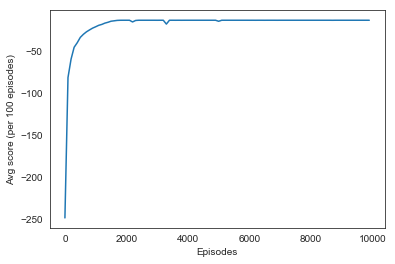

In [131]:
def sarsa(env, num_episodes, alpha, epsilon, gamma):
    tmp_scores = deque(maxlen=100)
    avg_scores = deque(maxlen=num_episodes)
    agent = Agent(env, alpha, gamma)
    
    for i_episode in range(1, num_episodes+1):
        if (i_episode % 1000) == 0:
            print("\rEpisode: {}/{}".format(i_episode, num_episodes), end="")
        
        epsilon = 1.0/ i_episode #max(1.0/ i_episode, 0.005)
        state = env.reset()
        action = agent.act(state, epsilon)
        score = 0.0
        while True:
            next_state, reward, done, info = env.step(action)
            next_action = agent.act(next_state, epsilon)
            agent.update_Q(state, action, reward, next_state, next_action, "sarsa")
            state = next_state
            action = next_action
            score+=reward
            if done:
                tmp_scores.append(score)
                break
        if i_episode % 100 == 0:
            avg_scores.append(np.mean(tmp_scores))
    return agent.Q, avg_scores

num_episodes = 10000
Q_sarsa, avg_scores = sarsa(env, num_episodes, 0.02, 0.005, 1.0)

plt.plot(np.arange(1, num_episodes+1, 100), avg_scores)
plt.xlabel("Episodes")
plt.ylabel("Avg score (per 100 episodes)")


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 3  2  1  1  1  1  1  3  1  1  1  2]
 [ 0  2  2  1  1  1  2  2  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


C:\Users\windo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\windo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\windo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\windo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as 

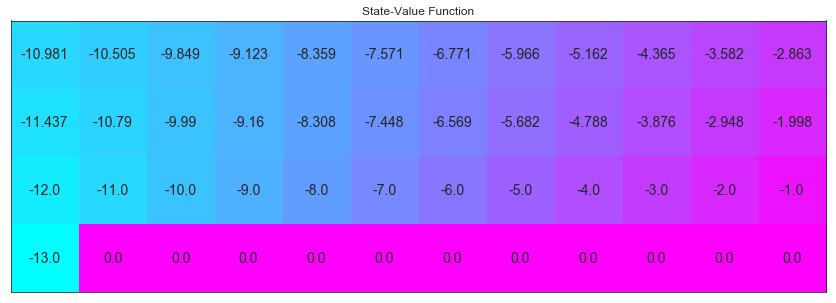

In [132]:
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### SARSA-MAX

Episode: 10000/10000

Text(0,0.5,'Avg score (per 100 episodes)')

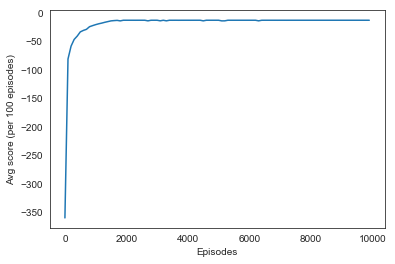

In [122]:
def sarsamax(env, num_episodes, alpha, epsilon, gamma):
    tmp_scores = deque(maxlen=100)
    avg_scores = deque(maxlen=num_episodes)
    agent = Agent(env, alpha, gamma)
    
    for i_episode in range(1, num_episodes+1):
        if (i_episode % 1000) == 0:
            print("\rEpisode: {}/{}".format(i_episode, num_episodes), end="")
        
        epsilon = 1.0/ i_episode #max(epsilon*0.9995, 0.01)
        state = env.reset()
        score = 0
        while True:
            action = agent.act(state, epsilon)
            next_state, reward, done, info = env.step(action)
            agent.update_Q(state, action, reward, next_state, None, "sarsamax")
            state = next_state
            score+=reward
            if done:
                tmp_scores.append(score)
                break
        if i_episode % 100 == 0:
            avg_scores.append(np.mean(tmp_scores))
    return agent.Q, avg_scores

num_episodes = 10000
Q_sarsamax, avg_scores_sarsamax = sarsamax(env, num_episodes, 0.02, 0.005, 1.0)

plt.plot(np.arange(1, num_episodes+1, 100), avg_scores_sarsamax)
plt.xlabel("Episodes")
plt.ylabel("Avg score (per 100 episodes)")


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  1  2  0  1  0  1  1  1  3  1  2]
 [ 0  1  1  1  1  1  1  3  1  2  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


C:\Users\windo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\windo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\windo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\windo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as 

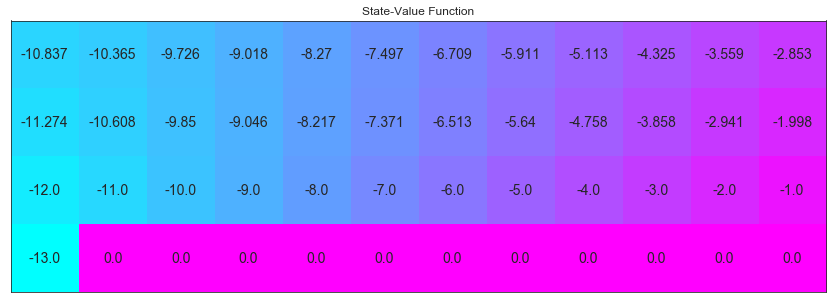

In [123]:
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Expected SARSA

Episode: 10000/10000

Text(0,0.5,'Avg score (per 100 episodes)')

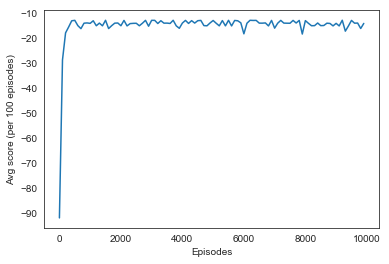

In [134]:
def expected_sarsa(env, num_episodes, alpha, epsilon, gamma):
    tmp_scores = deque(maxlen=100)
    avg_scores = deque(maxlen=num_episodes)
    agent = Agent(env, alpha, gamma)
    
    for i_episode in range(1, num_episodes+1):
        if (i_episode % 1000) == 0:
            print("\rEpisode: {}/{}".format(i_episode, num_episodes), end="")
        
        epsilon = 0.005 #max(epsilon*0.9995, 0.005)
        state = env.reset()
        score = 0
        while True:
            action = agent.act(state, epsilon)
            next_state, reward, done, info = env.step(action)
            agent.update_Q(state, action, reward, next_state, None, "expected_sarsa")
            state = next_state
            score+=reward
            if done:
                tmp_scores.append(score)
                break
        if i_episode % 100 == 0:
            avg_scores.append(np.mean(tmp_scores))
    return agent.Q, avg_scores

num_episodes = 10000
Q_expsarsa, avg_scores_expsarsa = expected_sarsa(env, num_episodes, 0.1, 0.005, 1.0)
plt.plot(np.arange(1, num_episodes+1, 100), avg_scores_expsarsa)
plt.xlabel("Episodes")
plt.ylabel("Avg score (per 100 episodes)")


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  2  3  3  1  0  1  1  1  1  2  2]
 [ 1  3  1  2  1  3  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


C:\Users\windo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\windo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\windo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\windo\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as 

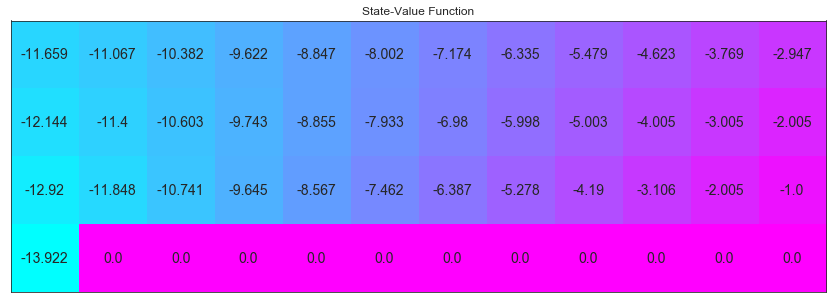

In [135]:
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])